In [2]:
!pip install CBFV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 8.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from CBFV.composition import generate_features

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
df_train = pd.read_csv("/content/cp_train.csv")
df_val= pd.read_csv("/content/cp_val.csv")
df_test= pd.read_csv("/content/cp_test.csv")

df_train.shape, df_test.shape, df_val.shape

((3203, 3), (368, 3), (976, 3))

In [8]:
rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = generate_features(df_val, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 3203/3203 [00:00<00:00, 26554.31it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 3203/3203 [00:00<00:00, 10186.39it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 976/976 [00:00<00:00, 26048.76it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 976/976 [00:00<00:00, 11354.51it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 368/368 [00:00<00:00, 22607.16it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 368/368 [00:00<00:00, 8600.73it/s]


	Creating Pandas Objects...


In [15]:
scaler= StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)
X_val = scaler.transform(X_val_unscaled)


In [31]:
class DenseNet(nn.Module):

    def __init__(self,
                 input_dims,
                 hidden_dims=[64, 32],
                 output_dims=1,
                 dropout=0.0):
        super().__init__()

        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims

        self.dropout = dropout

        # Build a sub-block of linear networks
        def fc_block(in_dim, out_dim, *args, **kwargs):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim, *args, **kwargs),
                nn.Dropout(p=self.dropout),
                nn.LeakyReLU()
                )

        # Build overall network architecture
        self.network = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(input_dims, self.hidden_dims[0]),
                    nn.Dropout(p=self.dropout),
                    nn.LeakyReLU())
                ]
            )

        hidden_layer_sizes = zip(self.hidden_dims[:-1], self.hidden_dims[1:])
        self.network.extend([
            fc_block(in_dim, out_dim) for in_dim, out_dim
            in hidden_layer_sizes]
            )

        self.network.extend([
            nn.Linear(hidden_dims[-1], output_dims)]
            )


    def forward(self, x):

        for i, subnet in enumerate(self.network):
            x = subnet(x)

        y = x

        return y

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
class CBFVDataLoader():

    def __init__(self, train_data, val_data, test_data,
                 batch_size=64, num_workers=1, random_state=42,
                 shuffle=True, pin_memory=True):

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        self.shuffle = shuffle
        self.random_state = random_state


    def get_data_loaders(self, batch_size=1):

        train_dataset = CBFVDataset(self.train_data)
        val_dataset = CBFVDataset(self.val_data)
        test_dataset = CBFVDataset(self.test_data)

        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  pin_memory=self.pin_memory,
                                  shuffle=self.shuffle)

        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                pin_memory=self.pin_memory,
                                shuffle=self.shuffle)

        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 pin_memory=self.pin_memory,
                                 shuffle=False)

        return train_loader, val_loader, test_loader


class CBFVDataset(Dataset):
    """
    Get X and y from CBFV-based dataset.
    """
    def __init__(self, dataset):
        self.data = dataset

        self.X = np.array(self.data[0])
        self.y = np.array(self.data[1])
        self.shape = [(self.X.shape), (self.y.shape)]

    def __str__(self):
        string = f'CBFVDataset with X.shape {self.X.shape}'
        return string

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        X = self.X[[idx], :]
        y = self.y[idx]

        X = torch.as_tensor(X)
        y = torch.as_tensor(np.array(y))

        return (X, y)

In [21]:
!pip install CBFV

In [29]:
train_data = (X_train, y_train)
val_data = (X_val, y_val)
test_data = (X_test, y_test)

# Instantiate the DataLoader
batch_size = 128
data_loaders = CBFVDataLoader(train_data, val_data, test_data, batch_size=batch_size)
train_loader, val_loader, test_loader = data_loaders.get_data_loaders()

In [32]:
example_data = train_loader.dataset.data[0]
input_dim= example_data.shape[-1]

model = DenseNet(input_dim,hidden_dims=[16], dropout=0.0)
print(model)

DenseNet(
  (network): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=309, out_features=16, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [35]:
criterion=nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [39]:
criterion= criterion.to(device)
model = model.to(device)


In [40]:
class Scaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.mean = torch.mean(self.data)
        self.std = torch.std(self.data)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (data - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled)
        data = data_scaled * self.std + self.mean
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


class MeanLogNormScaler():
    def __init__(self, data):
        self.data = torch.as_tensor(data)
        self.logdata = torch.log(self.data)
        self.mean = torch.mean(self.logdata)
        self.std = torch.std(self.logdata)

    def scale(self, data):
        data = torch.as_tensor(data)
        data_scaled = (torch.log(data) - self.mean) / self.std
        return data_scaled

    def unscale(self, data_scaled):
        data_scaled = torch.as_tensor(data_scaled) * self.std + self.mean
        data = torch.exp(data_scaled)
        return data

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [44]:
def predict(model, data_loader):
    target_list = []
    pred_list = []

    model.eval()
    with torch.no_grad():
        for i, data_output in enumerate(data_loader):
            X, y_act = data_output
            X = X.to(device,
                     dtype=data_type,
                     non_blocking=True)
            y_act = y_act.cpu().flatten().tolist()
            y_pred = model.forward(X).cpu().flatten().tolist()

            # Unscale target values
            y_pred = target_scaler.unscale(y_pred).tolist()

            targets = y_act
            predictions = y_pred
            target_list.extend(targets)
            pred_list.extend(predictions)
    model.train()

    return target_list, pred_list


def evaluate(target, pred):
    r2 = r2_score(target, pred)
    mae = mean_absolute_error(target, pred)
    rmse = mean_squared_error(target, pred, squared=False)
    output = (r2, mae, rmse)
    return output


def print_scores(scores, label=''):
    r2, mae, rmse = scores
    print(f'{label} r2: {r2:0.4f}')
    print(f'{label} mae: {mae:0.4f}')
    print(f'{label} rmse: {rmse:0.4f}')
    return scores


def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')

    return plot

In [42]:
y_train = [data[1].numpy().tolist() for data in train_loader]
y_train = [item for sublist in y_train for item in sublist]

y_train = train_loader.dataset.y

target_scaler = MeanLogNormScaler(y_train)

epoch: 0
train r2: -0.0877
train mae: 48.4450
train rmse: 63.1718
val r2: -0.0500
val mae: 56.6842
val rmse: 81.7831


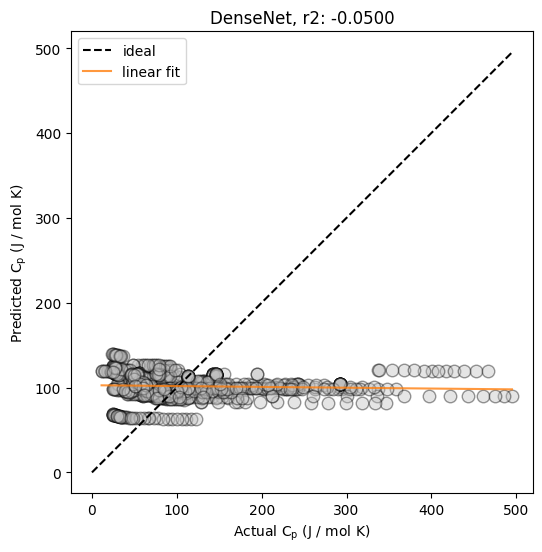

epoch: 20
epoch: 40
train r2: 0.9695
train mae: 6.8781
train rmse: 10.5844
val r2: 0.9028
val mae: 14.8045
val rmse: 24.8864


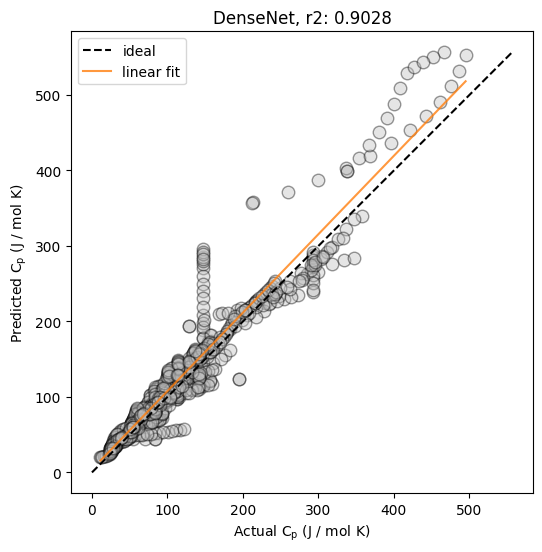

epoch: 60
epoch: 80
epoch: 100
train r2: 0.9751
train mae: 5.7626
train rmse: 9.5612
val r2: 0.8824
val mae: 14.3880
val rmse: 27.3749


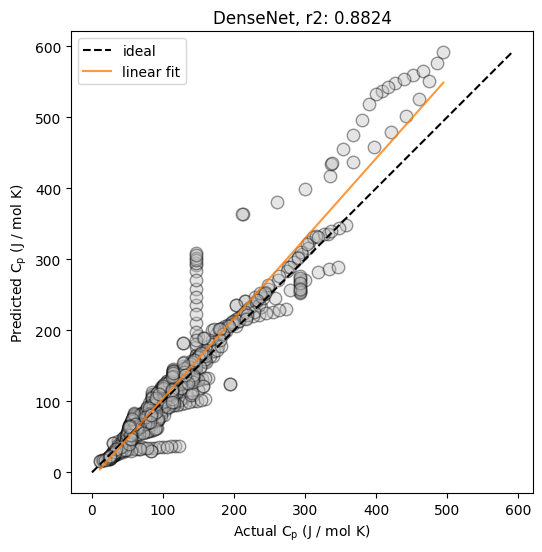

epoch: 120
epoch: 140
train r2: 0.9773
train mae: 5.3211
train rmse: 9.1259
val r2: 0.9259
val mae: 13.0191
val rmse: 21.7221


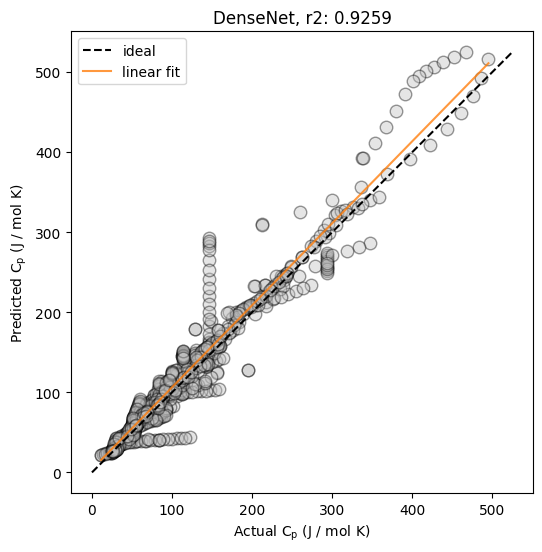

epoch: 160
epoch: 180
epoch: 200
train r2: 0.9817
train mae: 4.9944
train rmse: 8.2047
val r2: 0.9172
val mae: 12.8385
val rmse: 22.9620


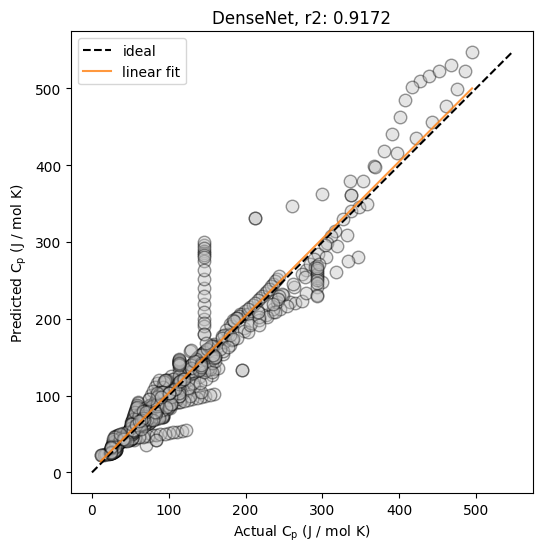

epoch: 220
epoch: 240
train r2: 0.9794
train mae: 5.1359
train rmse: 8.6947
val r2: 0.8719
val mae: 15.1726
val rmse: 28.5646


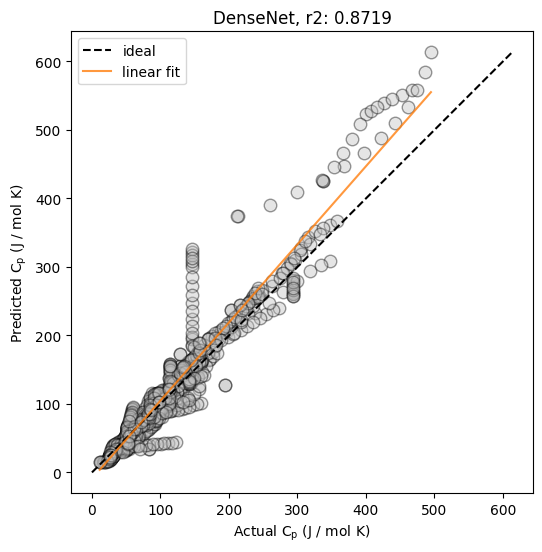

epoch: 260
epoch: 280
epoch: 300
train r2: 0.9809
train mae: 4.8519
train rmse: 8.3678
val r2: 0.9270
val mae: 12.4820
val rmse: 21.5660


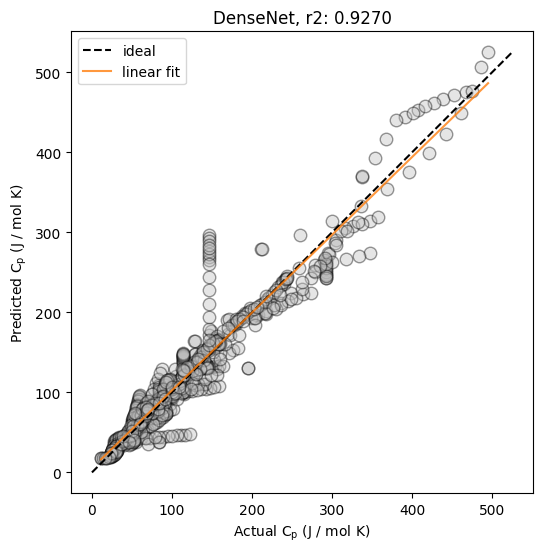

epoch: 320
epoch: 340
train r2: 0.9750
train mae: 5.7116
train rmse: 9.5691
val r2: 0.8612
val mae: 16.8429
val rmse: 29.7359


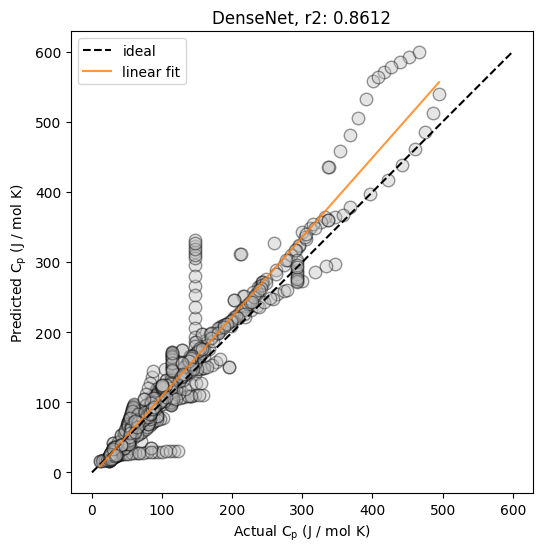

epoch: 360
epoch: 380
epoch: 400
train r2: 0.9856
train mae: 4.0407
train rmse: 7.2694
val r2: 0.8979
val mae: 15.0680
val rmse: 25.5026


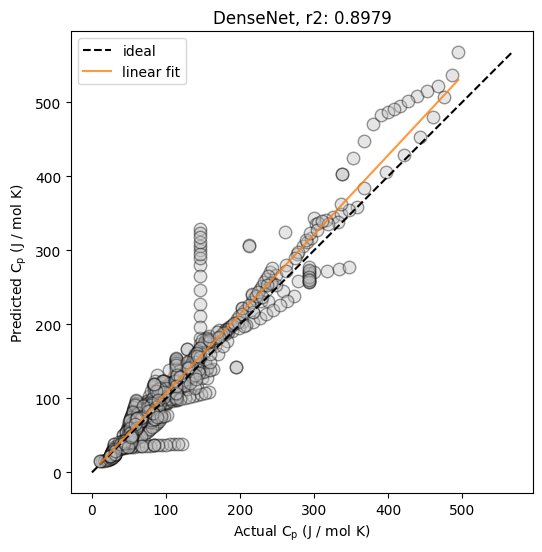

epoch: 420
epoch: 440
train r2: 0.9853
train mae: 4.1767
train rmse: 7.3363
val r2: 0.8796
val mae: 14.8027
val rmse: 27.6898


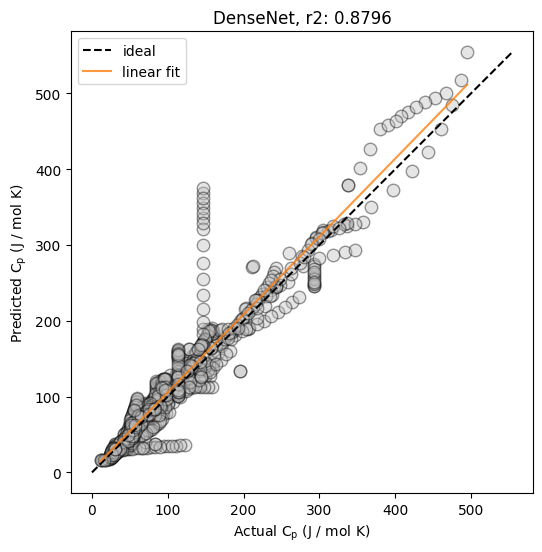

epoch: 460
epoch: 480
epoch: 499


In [46]:
data_type = torch.float
epochs = 500

print_every = 20
plot_every = 50

for epoch in range(epochs):
    if epoch % print_every == 0 or epoch == epochs - 1:
        print(f'epoch: {epoch}')
    if epoch % plot_every == 0:
        target_train, pred_train = predict(model, train_loader)
        train_scores = evaluate(target_train, pred_train)
        print_scores(train_scores, label='train')

        target_val, pred_val = predict(model, val_loader)
        val_scores = evaluate(target_val, pred_val)
        print_scores(val_scores, label='val')
        plot_pred_act(target_val, pred_val, model, label='$\mathrm{C}_\mathrm{p}$ (J / mol K)')
        plt.show()

    for i, data_output in enumerate(train_loader):
        X, y = data_output
        y = target_scaler.scale(y)

        X = X.to(device,
                 dtype=data_type,
                 non_blocking=True)
        y = y.to(device,
                 dtype=data_type,
                 non_blocking=True)

        optimizer.zero_grad()
        output = model.forward(X).flatten()
        loss = criterion(output.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

In [48]:
target_value, pred_value= predict(model, val_loader)
scores = evaluate(target_value, pred_val)
scores

(-1.186421429588946, 81.29851726012151, 118.01683873428024)